In [23]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os

sns.set_style("white")



In [75]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [76]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(\d+)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?")
    def __init__(self, filename):
        print(filename)
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = int(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))

    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

In [121]:

def plot(xs_by_config, ys_by_config, xlabel, ylabel, plot_dir, smoothing=0):
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):

        xs = xs_by_config[config]
        if config.trial != 2:
            continue

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]

        if config.trial:
            label = "{}, {}, top_{}/{}, lr={}, trial-{}".format(config.strategy,
                                                                config.network,
                                                           config.top_k,
                                                           config.pool_size,
                                                           config.lr,
                                                           config.trial)
        else:
            label = "{}, {}, top_{}/{}, lr={}".format(config.strategy,
                                                      config.network,
                                                      config.top_k,
                                                 config.pool_size,
                                                 config.lr)
        print xlabel, ",", ylabel, len(xs), len(ys)
        if config.top_k == config.pool_size:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=0.6)
        else:
            plt.plot(xs, ys, label=label, linewidth=0.6)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    plt.legend()
    plot_file = "{}_{}_{}_{}_top{}_ps{}_lr{}.png".format(config.dataset,
                                                      config.strategy,
                                                      ylabel,
                                                      config.network,
                                                      config.top_k,
                                                      config.pool_size,
                                                      config.lr)

    plt.savefig(os.path.join(plot_dir, plot_file))
    plot_file = "{}_{}_{}_{}_top{}_ps{}_lr{}.pdf".format(config.dataset,
                                                      config.strategy,
                                                      ylabel,
                                                      config.network,
                                                      config.top_k,
                                                      config.pool_size,
                                                      config.lr)
    plt.savefig(os.path.join(plot_dir, plot_file))
    plt.show()
    plt.clf()


In [122]:
def plot_experiment(experiment_dir, plot_dir, smoothing=0):
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}

    for filename in os.listdir(experiment_dir):
        if filename == ".DS_Store":
            continue
        elif filename == "pickles":
            continue

        filepath = os.path.join(experiment_dir, filename)
        config = Config(filename)
        train_lines, test_lines = parse_file(filepath)

        train_num_backprops = [l.num_backprop for l in train_lines]
        test_num_backprops = [l.num_backprop for l in test_lines]
        train_losses = [l.loss for l in train_lines]
        test_losses = [l.loss for l in test_lines]
        train_accuracies = [l.acc for l in train_lines]
        test_accuracies = [l.acc for l in test_lines]

        train_num_backprops_by_config[config] = train_num_backprops
        test_num_backprops_by_config[config] = test_num_backprops
        train_losses_by_config[config] = train_losses
        test_losses_by_config[config] = test_losses
        train_accuracies_by_config[config] = train_accuracies
        test_accuracies_by_config[config] = test_accuracies


    plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Trained", "Training Loss", plot_dir, smoothing)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Trained", "Test Accuracy", plot_dir, smoothing)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Trained", "Test Loss", plot_dir, smoothing)

sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_32_32_0.001_0.0001_trial1_v2


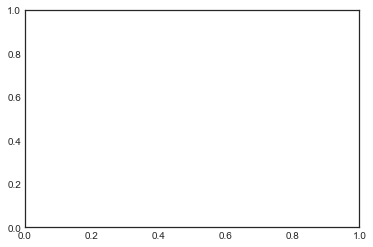

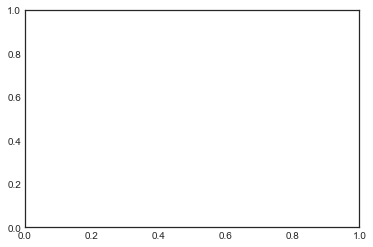

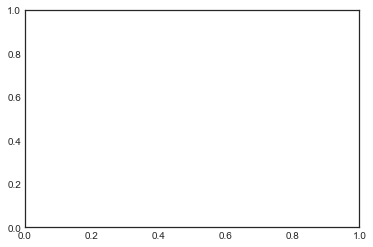

<Figure size 432x288 with 0 Axes>

In [123]:
plot_home_dir = "../plots"

experiment_name = "180924"
experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_experiment(experiment_dir, plot_dir, 3)

sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial2_v2
sampling_cifar10_mobilenet_0_32_0.001_0.0001_trial3_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial1_v2
sampling_cifar10_resnet_0_32_0.001_0.0001_trial2_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial1_v2
topk_cifar10_mobilenet_24_32_0.001_0.0001_trial2_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial1_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial2_v2
topk_cifar10_resnet_32_32_0.001_0.0001_trial3_v2
Num Images Trained , Training Loss 13673 13673
Num Images Trained , Training Loss 48582 48582
Num Images Trained , Training Loss 31189 31189
Num Images Trained , Training Loss 43729 43729


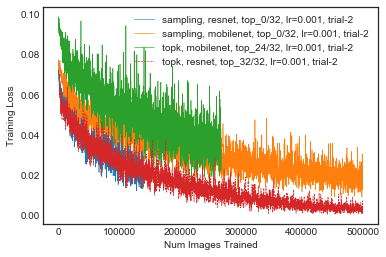

Num Images Trained , Test Accuracy 488 488
Num Images Trained , Test Accuracy 1742 1742
Num Images Trained , Test Accuracy 1118 1118
Num Images Trained , Test Accuracy 1568 1568


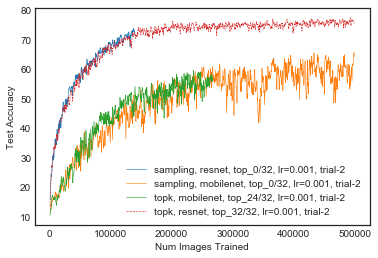

Num Images Trained , Test Loss 488 488
Num Images Trained , Test Loss 1742 1742
Num Images Trained , Test Loss 1118 1118
Num Images Trained , Test Loss 1568 1568


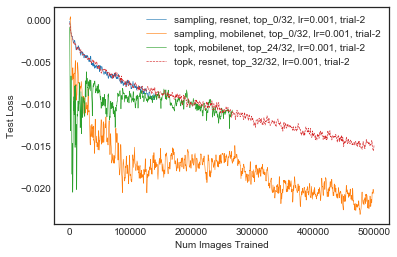

<Figure size 432x288 with 0 Axes>

In [124]:
plot_home_dir = "../plots"

experiment_name = "180924b"
experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_experiment(experiment_dir, plot_dir, 3)